---
title: Anomaly detection on UCI Air Quality dataset (Temperature)
format:
  html:
    self-contained: true
    echo: false
    output: false
    page-layout: full
jupyter: python3
tbl-cap-location: margin
---

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

from datetime import date
from ucimlrepo import fetch_ucirepo
from IPython.display import Markdown as md

## Outline

1. Load dataset
2. Preprocessing
3. Separate historical static data (3 months cutoff)
4. Create train / val splits
5. Inspect temporal distribution of temperature (`T`) feature in train set
6. Standardize splits
7. Learn normal boundary with *LOF*
8. Make predictions on the validation set
9. Visualize how seasonal effects make detector outdated
10. Conclusions and limitations

## Dataset

In [ ]:
# fetch dataset 
air_quality = fetch_ucirepo(id=360) 
  
# data (as pandas dataframes) 
X = air_quality.data.features 
  
# metadata 
print(air_quality.metadata) 
  
# variable information 
print(air_quality.variables) 

{'uci_id': 360, 'name': 'Air Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/360/air+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/360/data.csv', 'abstract': 'Contains the responses of a gas multisensor device deployed on the field in an Italian city. Hourly responses averages are recorded along with gas concentrations references from a certified analyzer. ', 'area': 'Computer Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 9358, 'num_features': 15, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C59K5F', 'creators': ['Saverio Vito'], 'intro_paper': {'ID': 420, 'type': 'NATIVE', 'title': 'On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario', 'authors': 

In [12]:
#| output: true
#| label: tbl-dataset
#| tbl-cap: "Original dataset"
X

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,4/4/2005,10:00:00,3.1,1314,-200,13.5,1101,472,539,190,1374,1729,21.9,29.3,0.7568
9353,4/4/2005,11:00:00,2.4,1163,-200,11.4,1027,353,604,179,1264,1269,24.3,23.7,0.7119
9354,4/4/2005,12:00:00,2.4,1142,-200,12.4,1063,293,603,175,1241,1092,26.9,18.3,0.6406
9355,4/4/2005,13:00:00,2.1,1003,-200,9.5,961,235,702,156,1041,770,28.3,13.5,0.5139


## Preprocessing

In [14]:
#| echo: true
X['Date'] = pd.to_datetime(X['Date'], format='%m/%d/%Y').dt.date
X['Time_hour'] = pd.to_datetime(X['Time']).dt.hour

/var/folders/_8/wrnf3yvs3jg52zw_72p2w64w0000gn/T/ipykernel_37820/3025546830.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X['Time_hour'] = pd.to_datetime(X['Time']).dt.hour


In [17]:
#| output: true
#| label: tbl-dataset-preprocessed
#| tbl-cap: "Preprocessed dataset"
X

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Time_hour
0,2004-03-10,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578,18
1,2004-03-10,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255,19
2,2004-03-10,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502,20
3,2004-03-10,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867,21
4,2004-03-10,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,2005-04-04,10:00:00,3.1,1314,-200,13.5,1101,472,539,190,1374,1729,21.9,29.3,0.7568,10
9353,2005-04-04,11:00:00,2.4,1163,-200,11.4,1027,353,604,179,1264,1269,24.3,23.7,0.7119,11
9354,2005-04-04,12:00:00,2.4,1142,-200,12.4,1063,293,603,175,1241,1092,26.9,18.3,0.6406,12
9355,2005-04-04,13:00:00,2.1,1003,-200,9.5,961,235,702,156,1041,770,28.3,13.5,0.5139,13


## Constructing historical data

The idea is to consider the approximately 3 months of data as a historical data at hand to train static machine learning models on.

In [27]:
HISTORICAL_CUTOFF_DATE = date(2004, 6, 10)

In [32]:
#| output: true
#| label: tbl-specific-dates
#| tbl-cap: "Range of `Date` and the specified cutoff date."
pd.Series(
    [date.strftime(X['Date'].min(), "%Y/%m/%d"), date.strftime(X['Date'].max(), "%Y/%m/%d"), HISTORICAL_CUTOFF_DATE.strftime("%Y/%m/%d")],
    index=["Min", "Max", "Historical cutoff"], name="Date").to_frame()


,Date
Min,2004/03/10
Max,2005/04/04
Historical cutoff,2004/06/10


In [33]:
#| output: true
#| label: tbl-x-historical
#| tbl-cap: "The designated historical data."
X_historical = X[X['Date'] < HISTORICAL_CUTOFF_DATE]
X_historical

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Time_hour
0,2004-03-10,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578,18
1,2004-03-10,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255,19
2,2004-03-10,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502,20
3,2004-03-10,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867,21
4,2004-03-10,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,2004-06-09,19:00:00,4.6,1357,-200,25.6,1445,295,620,206,2195,1622,33.7,27.7,1.4213,19
2186,2004-06-09,20:00:00,3.4,1234,-200,18.6,1257,212,695,162,2019,1349,30.7,32.2,1.3983,20
2187,2004-06-09,21:00:00,2.7,1151,-200,15.2,1154,151,747,132,1894,1186,28.4,35.7,1.3549,21
2188,2004-06-09,22:00:00,1.9,1065,-200,11.7,1038,110,805,107,1763,1026,26.5,38.6,1.3154,22


## Splitting the data

In [34]:
#| echo: true
#| output: true

X_train = X_historical[X_historical['Date'] < date(2004, 6, 1)]
X_val = X_historical[X_historical['Date'] >= date(2004, 6, 1)]

(X_train.shape, X_val.shape)

((1974, 16), (216, 16))

## Inspect training set

In [35]:
X_train_inspect = X_train[['Date', 'Time_hour', 'T']]
X_train_inspect

,Date,Time_hour,T
0,2004-03-10,18,13.6
1,2004-03-10,19,13.3
2,2004-03-10,20,11.9
3,2004-03-10,21,11.0
4,2004-03-10,22,11.2
...,...,...,...
1969,2004-05-31,19,24.5
1970,2004-05-31,20,21.7
1971,2004-05-31,21,19.3
1972,2004-05-31,22,17.6


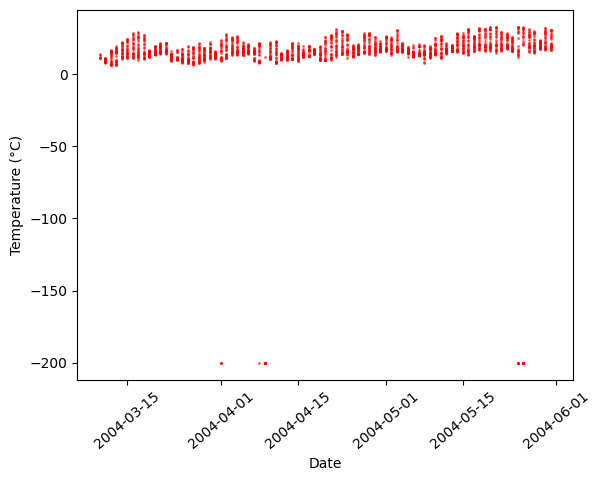

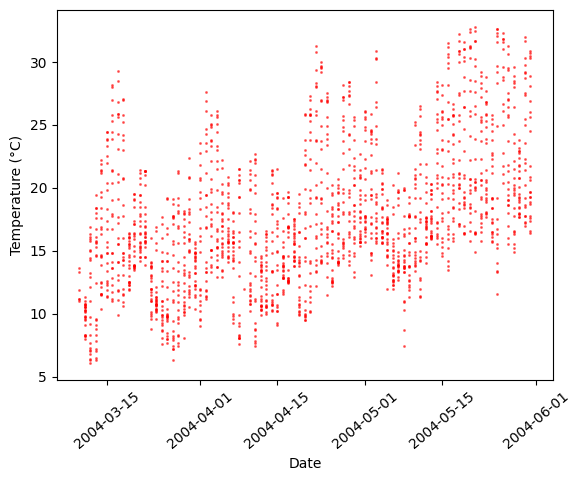

In [ ]:
#| output: true
#| label: fig-historical-temp-over-date
#| fig-cap: "Temperature over dates of historical data window (training data)."
#| fig-subcap:
#|  - "Missing values (-200) included"
#|  - "Missing values ignored"
#| layout: [1, 1]

plt.scatter(X_train['Date'], X_train['T'], marker=".", alpha=.5, s=5, color="red")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.xticks(rotation=40)
plt.show()

plt.scatter(X_train[X_train['T'] != -200]['Date'], X_train[X_train['T'] != -200]['T'], marker=".", alpha=.5, s=5, color="red")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.xticks(rotation=40)
plt.show()

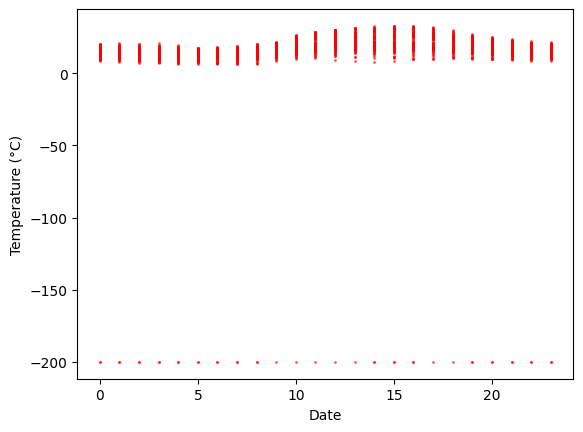

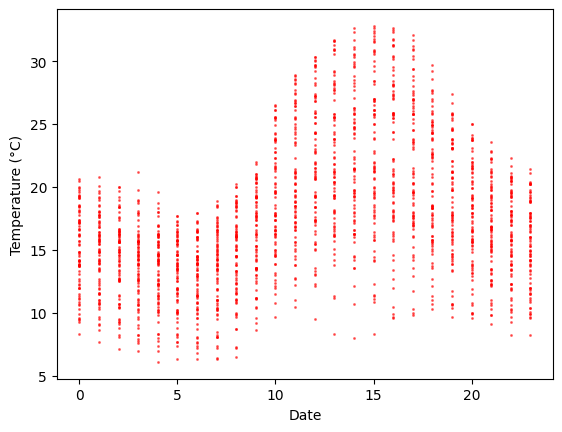

In [ ]:
#| output: true
#| label: fig-historical-temp-over-time
#| fig-cap: "Temperature over time of historical data window (training data)."
#| fig-subcap:
#|  - "Missing values (-200) included"
#|  - "Missing values ignored"
#| layout: [1, 1]

plt.scatter(X_train['Time_hour'], X_train['T'], marker=".", alpha=.5, s=5, color="red")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()

plt.scatter(X_train[X_train['T'] != -200]['Time_hour'], X_train[X_train['T'] != -200]['T'], marker=".", alpha=.5, s=5, color="red")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()

In [59]:
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

## Train anomaly detector

In [ ]:
X_train_fit = X_train[['Time_hour', 'T']].copy()
X_train_fit.loc[X_train_fit['T'] == -200, 'T'] = pd.NA

display(X_train_fit.shape)
X_train_fit.dropna(inplace=True)
display(X_train_fit.shape)


(1974, 2)

(1933, 2)

In [66]:
scaler = StandardScaler()
scaler.fit(X_train_fit)

X_train_fit_scaled = pd.DataFrame(scaler.transform(X_train_fit), columns=['Time_hour', 'T'])

In [67]:
lof = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.05)
lof.fit(X_train_fit_scaled)

LocalOutlierFactor(contamination=0.05, novelty=True)

/Users/matebalogh/Documents/Learning/ELTE - Data Science/Data Science/OST-SM/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


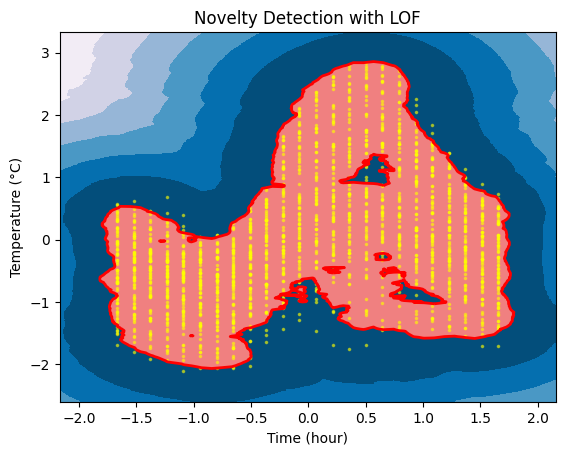

In [ ]:
#| output: true

xx, yy = np.meshgrid(np.linspace(min(X_train_fit_scaled['Time_hour']) -.5, max(X_train_fit_scaled['Time_hour']) +.5), np.linspace(min(X_train_fit_scaled['T']) -.5, max(X_train_fit_scaled['T'] +.5), 500))
Z = lof.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection with LOF")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="red")
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="lightcoral")

plt.scatter(X_train_fit_scaled['Time_hour'], X_train_fit_scaled['T'], marker=".", alpha=.5, s=10, color="yellow")
plt.xlabel("Time (hour)")
plt.ylabel("Temperature (°C)")

plt.show()

## Predictions

In [ ]:
y_train_hat_missing = lof.predict(X_train[X_train['T'] == -200][['Time_hour', 'T']])
np.unique(y_train_hat_missing, return_counts=True)

/Users/matebalogh/Documents/Learning/ELTE - Data Science/Data Science/OST-SM/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


(array([-1]), array([41]))

In [78]:
X_val_eval = X_val[['Time_hour', 'T']].copy()
X_val_eval_scaled = pd.DataFrame(scaler.transform(X_val_eval), columns=['Time_hour', 'T'])

In [ ]:
y_val_hat = lof.predict(X_val_eval_scaled)
np.unique(y_val_hat, return_counts=True)

/Users/matebalogh/Documents/Learning/ELTE - Data Science/Data Science/OST-SM/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


(array([-1,  1]), array([111, 105]))

/Users/matebalogh/Documents/Learning/ELTE - Data Science/Data Science/OST-SM/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


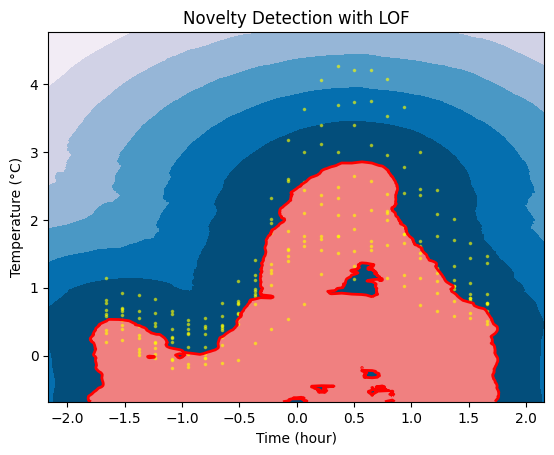

In [82]:
#| output: true

xx, yy = np.meshgrid(np.linspace(min(X_val_eval_scaled['Time_hour']) -.5, max(X_val_eval_scaled['Time_hour']) +.5), np.linspace(min(X_val_eval_scaled['T']) -.5, max(X_val_eval_scaled['T'] +.5), 500))
Z = lof.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection with LOF")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="red")
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="lightcoral")

plt.scatter(X_val_eval_scaled['Time_hour'], X_val_eval_scaled['T'], marker=".", alpha=.5, s=10, color="yellow")
plt.xlabel("Time (hour)")
plt.ylabel("Temperature (°C)")

plt.show()

Anomalies in the original space:

In [ ]:
#| output: true
X_val[y_val_hat == -1][['Date', 'Time', 'T']].sort_values(by=['Date', 'Time'])

,Date,Time,T
2017,2004-06-02,19:00:00,26.2
2018,2004-06-02,20:00:00,24.5
2019,2004-06-02,21:00:00,22.8
2020,2004-06-02,22:00:00,21.9
2021,2004-06-02,23:00:00,21.7
...,...,...,...
2171,2004-06-09,5:00:00,20.3
2172,2004-06-09,6:00:00,20.5
2173,2004-06-09,7:00:00,21.7
2174,2004-06-09,8:00:00,23.4
